In [15]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import torchdata
import torch.nn as nn
import torch
from PIL import ImageColor
device = device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.is_available(), torch.__version__


(True, '2.0.0+cu118')

In [16]:
# # class_to_idx = {cls: idx for (idx, cls) in enumerate(FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.meta["categories"])}
# class_to_idx = {
#     '__background__': 0,
#     'road_surface': 1,
#     'marking': 2,
#     'car': 3,
#     'road_sign': 4,
# }

In [17]:
class_to_idx = {
    '__background__': 0,
    'road_surface': 1,
    'marking': 2,
    'car': 3,
    'road_sign': 4,
}

class_to_color = {
    '__background__': ImageColor.getcolor("#b83df5", "RGB"),
    'road_surface': ImageColor.getcolor("#3d3df5", "RGB"),
    'marking': ImageColor.getcolor("#ddff33", "RGB"),
    'car': ImageColor.getcolor("#ffcc33", "RGB"),
    'road_sign': ImageColor.getcolor("#ff355e", "RGB"),
    
}

torch.Size([3, 720, 1280])


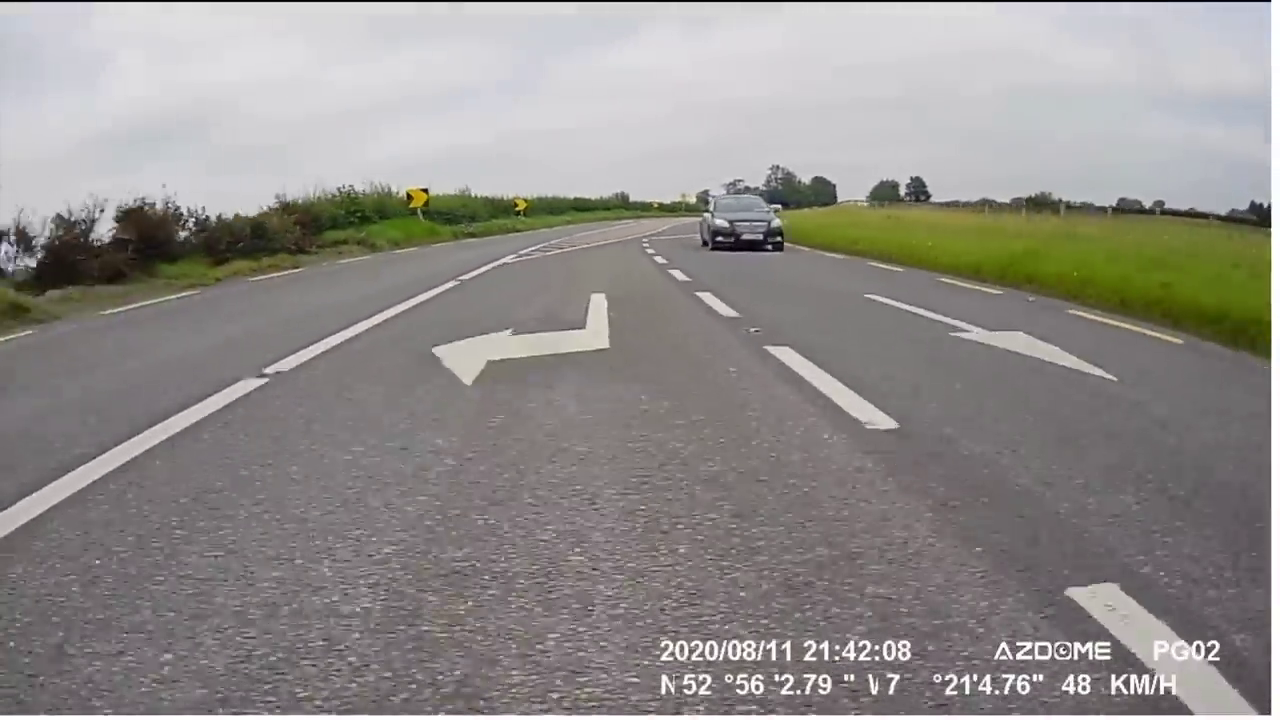

In [18]:
img = Image.open("./data/images/0.png")
img_tensor= pil_to_tensor(img)
mask = Image.open("./data/masks/0.png").convert('RGB')
mask_tensor= pil_to_tensor(mask)
print(img_tensor.shape)
img

# Reshape model

In [19]:
fcn_resnet = fcn_resnet50(weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
for i in fcn_resnet.parameters():
    i.requires_grad = False
maskrcnn_resnet = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
img_preprocessor = FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms(resize_size=None)
maskrcnn_resnet.eval()
fcn_resnet.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [20]:
fcn_resnet.classifier[4] = nn.Conv2d(512, 5, kernel_size=(1, 1), stride=(1, 1))
for i in fcn_resnet.classifier.parameters():
    i.requires_grad = True

In [21]:
for i in fcn_resnet.backbone.layer4[2].parameters():
    i.requires_grad = True

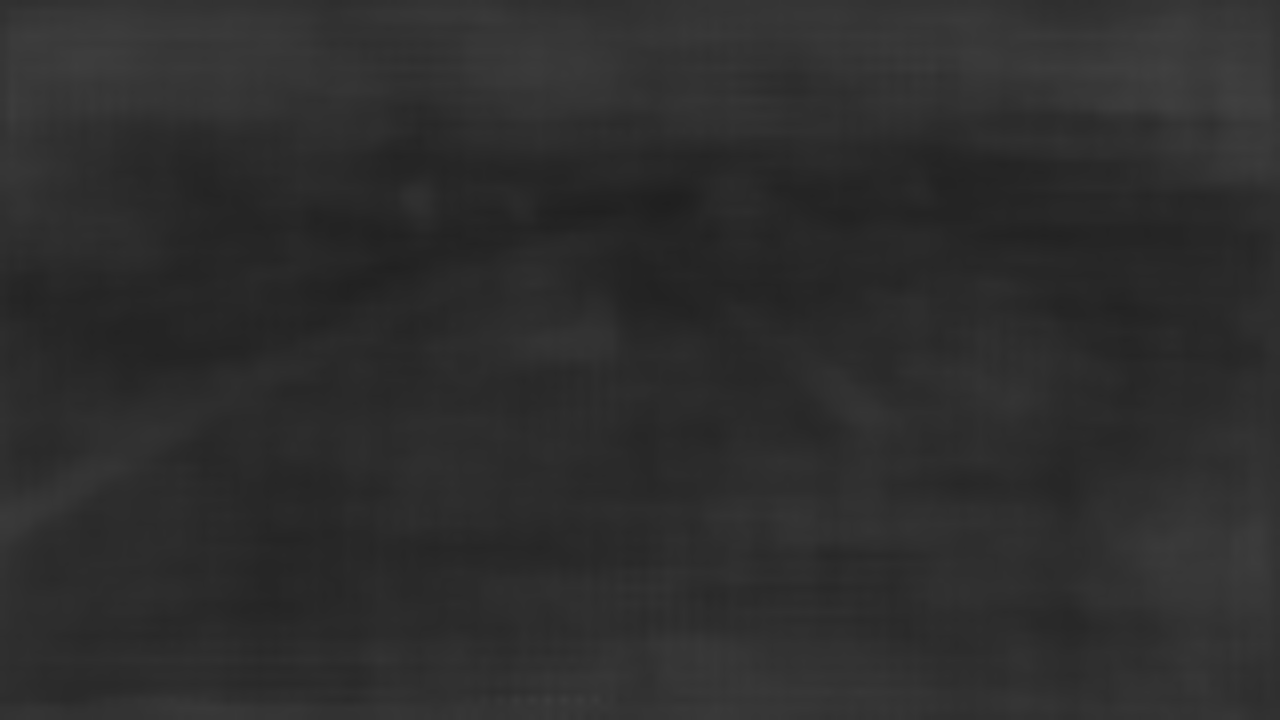

In [22]:
segmented_img = fcn_resnet(img_preprocessor(img_tensor).unsqueeze(dim=0))
prediction = segmented_img['out']
normalized_masks = prediction.softmax(dim=1)[0]
to_pil_image(normalized_masks[class_to_idx['__background__']])

In [23]:
segmented_img['out'].shape

torch.Size([1, 5, 720, 1280])

# Prepear dataset

In [24]:
import pandas as pd
from torchdata import datapipes
import torch
from PIL import ImageColor

In [25]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1
  

def imageLoader(pair):
    return pil_to_tensor(Image.open(pair[0])), pil_to_tensor(Image.open(pair[1]).convert('RGB'))


def prepearImage(pair):
   x = img_preprocessor(pair[0]).unsqueeze(dim=0)
   y = pair[1]
   y.requires_grad = False
   return x, y


In [26]:
batch_size = 3

In [27]:
data_c_len = pd.read_csv('data/images_masks_pathes_pairs.csv').shape[0]
output_res = torchdata.datapipes.iter.IterableWrapper(['data/images_masks_pathes_pairs.csv'])
output_res_pipe = torchdata.datapipes.iter.FileOpener(output_res, mode='r', encoding='utf-8', length=data_c_len)
res_pipe = output_res_pipe.parse_csv(skip_lines=1, delimiter=',')
res_pipe = torchdata.datapipes.map.SequenceWrapper(list(res_pipe))
ready = res_pipe.map(imageLoader)
ready = ready.map(prepearImage)
train_dataloader = torchdata.datapipes.map.Shuffler(ready).batch(batch_size=batch_size)

In [29]:
def processMaskToBin(img_msk, class_name):
    r = img_msk[0, :, :] == class_to_color[class_name][0]
    g = img_msk[1, :, :] == class_to_color[class_name][1]
    b = img_msk[2, :, :] == class_to_color[class_name][2]
    return r * g * b


def processBinMaskToDepth(img_bin_msk, class_name):
    m = torch.zeros([1, len(class_to_idx), *img_bin_msk.shape])
    m[:, class_to_idx[class_name], :, :] = img_bin_msk
    return m


def processMasksAllClasses(img_mask):
    k = 1
    for c in class_to_color:
        if k:
            k = 0
            m = processBinMaskToDepth(processMaskToBin(img_mask, c), c)
        else:
            m += processBinMaskToDepth(processMaskToBin(img_mask, c), c)
    return m


In [30]:
print_simple_data_pipe(train_dataloader, lambda a: f'batch_size: {len(a)}, {a[0][0].shape}, {processMasksAllClasses(a[0][1]).shape}', n=5)

<class 'torch.utils.data.datapipes.iter.grouping.BatcherIterDataPipe'>
batch_size: 3, torch.Size([1, 3, 720, 1280]), torch.Size([1, 5, 720, 1280])
batch_size: 3, torch.Size([1, 3, 720, 1280]), torch.Size([1, 5, 720, 1280])
batch_size: 3, torch.Size([1, 3, 720, 1280]), torch.Size([1, 5, 720, 1280])
batch_size: 3, torch.Size([1, 3, 720, 1280]), torch.Size([1, 5, 720, 1280])
batch_size: 3, torch.Size([1, 3, 720, 1280]), torch.Size([1, 5, 720, 1280])
batch_size: 3, torch.Size([1, 3, 720, 1280]), torch.Size([1, 5, 720, 1280])


# Train Model

In [16]:
from tqdm import tqdm

In [17]:
n_episodes = 100
n_steps = 20
loss = torch.nn.MultiMarginLoss()
optimizer = torch.optim.Adam(fcn_resnet.parameters(), lr=0.00001)

In [ ]:
# def resnetOutputsToClasses

In [77]:
fcn_resnet.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [78]:
device

device(type='cuda')

In [79]:
lm = []

In [80]:
for _ in tqdm(range(n_episodes)):
    e = n_steps
    for data in train_dataloader:
        x_t, y_t = [], []
        for x, y in data:
            x_t.append(x)
            y_t.append(processMasksAllClasses(y))
        x_t = torch.cat(x_t)
        y_t = torch.cat(y_t).squeeze()
        optimizer.zero_grad()
        prediction = fcn_resnet(x_t.to(device))['out']
        normalized_masks = prediction.softmax(dim=1).squeeze()
        l = loss(normalized_masks.reshape(batch_size, -1).to(device), y_t.reshape(batch_size, -1).to(device))
        l.backward()
        lm.append(l.item())
        e -= 1
        optimizer.step()
        if e < 0:
            break
    
    

100%|██████████| 100/100 [23:07<00:00, 13.87s/it]


In [81]:
# torch.save(fcn_resnet, './models/cel_r50.bin')

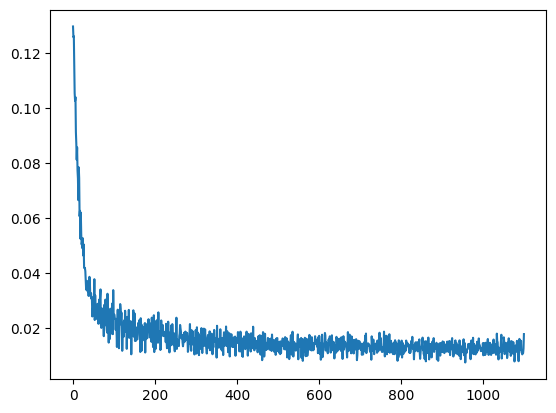

In [86]:
import matplotlib.pyplot as plt
plt.plot(lm)

In [87]:
normalized_masks.shape

torch.Size([5, 720, 1280])

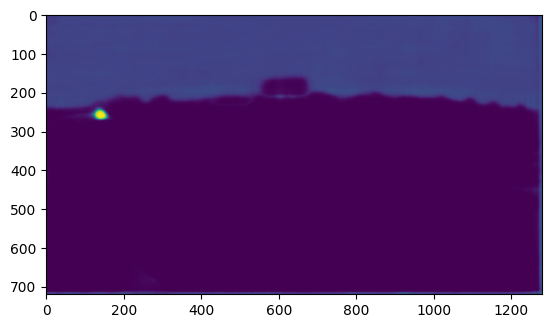

In [89]:
plt.imshow(normalized_masks[3].to('cpu').detach().numpy())

In [ ]:
# plt.imshow